In [1]:
# Repository locations
ATM_DIR = "/epyc/projects/atm/atm/"
ATM_DATA_DIR = "/epyc/projects/atm/atm_data/"

In [2]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from astroquery.jplsbdb import SBDB

sns.set(font_scale=0.8, 
        context="paper", 
        style="ticks", 
        rc={"axes.linewidth": 0.8})
sns.set_palette("viridis")

%matplotlib inline

import sys
sys.path.append(ATM_DIR)

from atm.obs import SDSS
from atm.models import NEATM
from atm.functions import calcQ
from atm.functions import calcPv
from atm.functions import calcD
from atm.analysis import calcColors
from atm.analysis import readSDSSMOC
from atm.analysis import _median
from atm.analysis import _sigmaG
from atm.analysis import calcStdDev
from atm.plotting import plotHist

In [3]:
DPI = 300
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = True

In [4]:
SIGMA = 0.15
RUN_DIR = os.path.join(ATM_DATA_DIR, "paper1/runs/sigma{}".format(int(SIGMA * 100)))
RUN_NAME = "run1"

In [5]:
results_database = os.path.join(RUN_DIR, "atm_results_{}.db".format(RUN_NAME))
con_results = sql.connect(results_database)
model_stats = pd.read_sql("""SELECT * FROM model_stats""", con_results)
observed_stats = pd.read_sql("""SELECT * FROM observed_stats""", con_results)

In [6]:
moc = readSDSSMOC()
moc = moc[(moc["identification_flag"] == 1)]
moc["numeration"] = moc["numeration"].astype(str)

In [7]:
# Add H values correction
moc["H_corr"] = moc["H_mag"] + moc["V_mag"] - moc["computed_mag"]
dH = moc["H_corr"] - moc["H_mag"]

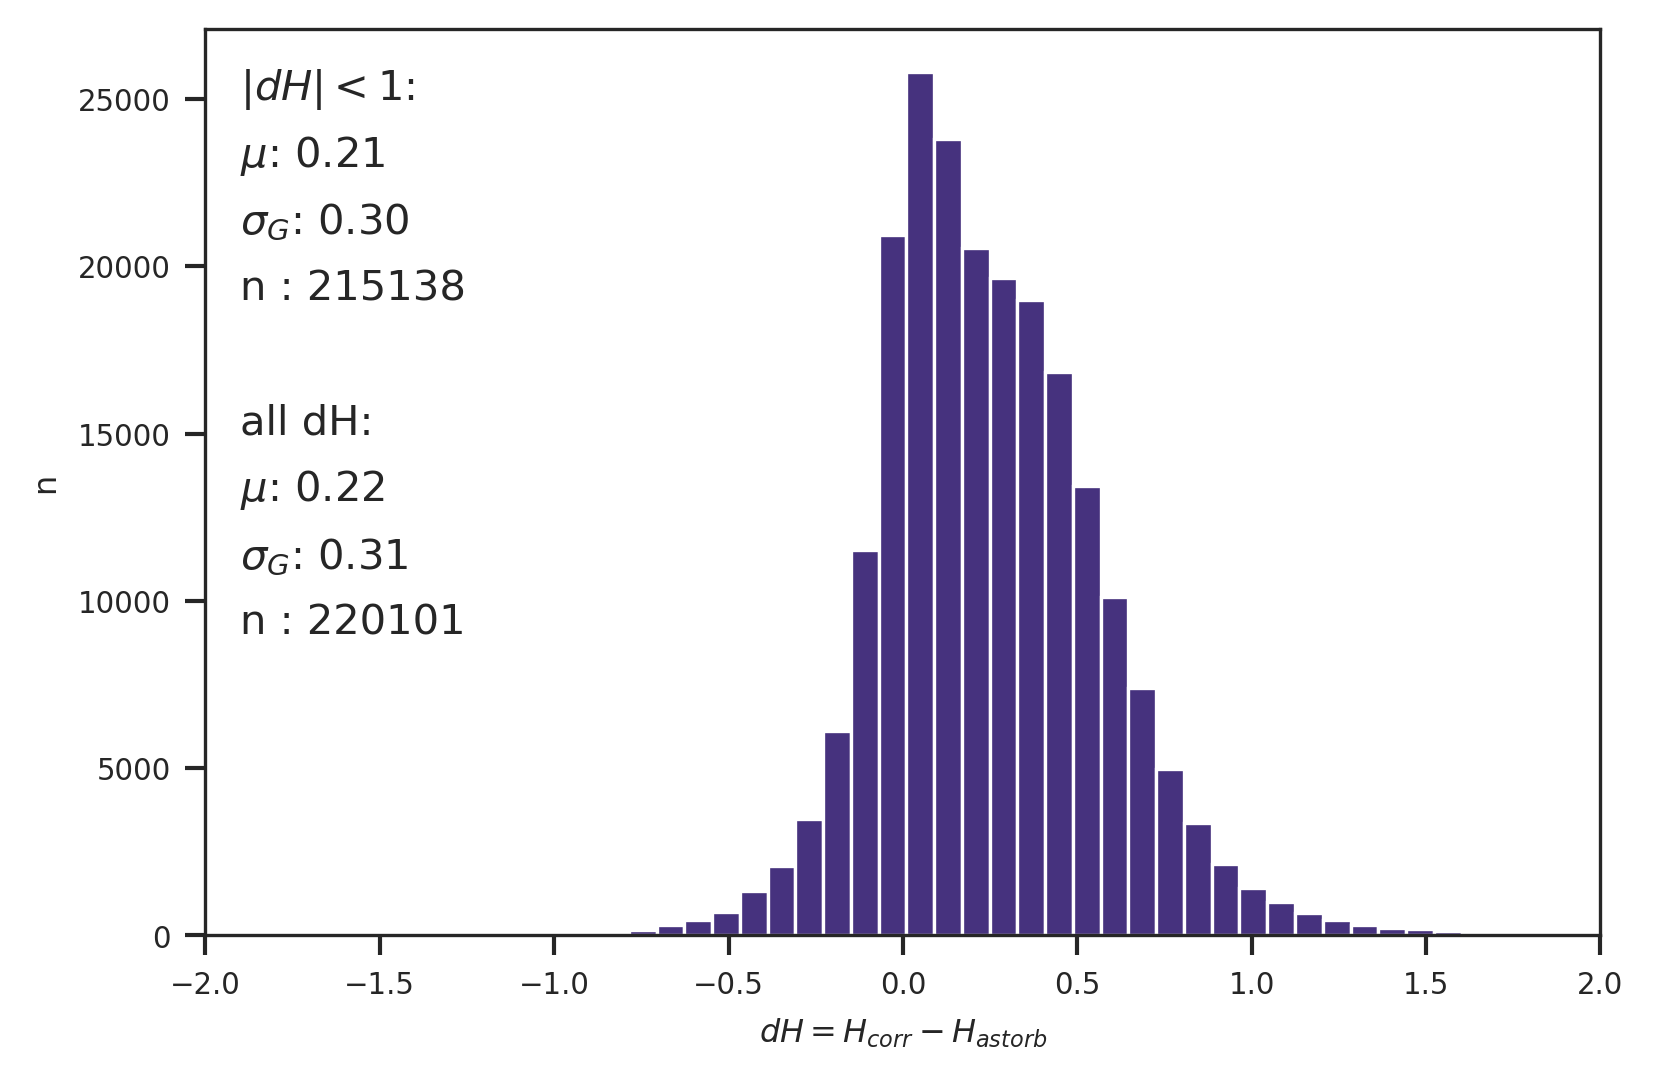

In [8]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.hist(dH[np.abs(dH) < 2], bins=50)
ax.set_xlim(-2, 2)
ax.text(-1.9, 25000, r"$\left | dH \right | < 1$:")
ax.text(-1.9, 23000, r"$\mu$: {:.2f}".format(np.median(dH[dH < 1])))
ax.text(-1.9, 21000, r"$\sigma_G$: {:.2f}".format(calcStdDev(dH[dH < 1])))
ax.text(-1.9, 19000, r"n : {}".format(len(dH[dH < 1])))
ax.text(-1.9, 15000, r"all dH:")
ax.text(-1.9, 13000, r"$\mu$: {:.2f}".format(np.median(dH)))
ax.text(-1.9, 11000, r"$\sigma_G$: {:.2f}".format(calcStdDev(dH)))
ax.text(-1.9, 9000, r"n : {}".format(len(dH)))
ax.set_xlabel(r"$dH = H_{corr} - H_{astorb}$")
ax.set_ylabel(r"n")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "dH.{}".format(FORMAT)),
                bbox_inches='tight')

In [9]:
# Calculate colors for SDSS MOC
obs = SDSS()

columnMapping = {
    "obs_id" : "mo_id",
    "mag" : ["{}_mag".format(i) for i in obs.filterNames]
}

moc_colors = calcColors(obs, moc, columnMapping=columnMapping)
moc = moc.merge(moc_colors, on="mo_id")

moc["a_color"] = 0.89 * moc["g-r"] + 0.45 * moc["r-i"] - 0.57

Calculating colors using these columns:
Magnitudes : u_mag, g_mag, r_mag, i_mag, z_mag
Creating colors: u-g, g-r, r-i, i-z
Done.



In [10]:
# modeled after http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
def compute_color(col_a, mag_i, mag_z, a_crit=-0.1):
    """
    Compute the scatter-plot color using code adapted from
    TCL source used in Parker 2008.
    """
    # define the base color scalings
    R = np.ones_like(mag_i)
    G = 0.5 * 10 ** (-2 * (mag_i - mag_z - 0.01))
    B = 1.5 * 10 ** (-8 * (col_a + 0.0))

    # enhance green beyond the a_crit cutoff
    G += 10. / (1 + np.exp((col_a - a_crit) / 0.02))

    # normalize color of each point to its maximum component
    RGB = np.vstack([R, G, B])
    RGB /= RGB.max(0)

    # return an array of RGB colors, which is shape (n_points, 3)
    return RGB.T

In [11]:
RGB = compute_color(moc["a_color"].values, moc["i_mag"].values, moc["z_mag"].values)
moc["r_color"] = RGB[:,0]
moc["g_color"] = RGB[:,1]
moc["b_color"] = RGB[:,2]

In [12]:
# Cross match numbered asteroids with ATM results (merge with both the model_stats and observed_stats DataFrames)
moc = moc[(moc["numeration"].isin(model_stats["designation"].unique()))]
moc.sort_values(by=["numeration", "mjd"], inplace=True)
#moc.drop_duplicates(subset=["numeration"], keep="first", inplace=True)

moc = moc.groupby(by="numeration").agg([_median, _sigmaG])
moc.rename(columns={"_median" : "median", "_sigmaG" : "sigmaG"}, inplace=True)
moc.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in moc.columns]
moc.reset_index(inplace=True)

merged_results = moc.merge(model_stats, left_on="numeration", right_on="designation", suffixes=("_moc", "_atm"))
merged_results = merged_results.merge(observed_stats, left_on="numeration", right_on="designation", suffixes=("_moc", "_atm"))

In [13]:
merged_results["pv"] = calcPv(10**merged_results["logD_median"].values, merged_results["H_corr_median"].values)
merged_results["p_W1W2_median"] = (1 - merged_results["eps_W1W2_median"].values) / calcQ(merged_results["G_median_atm"]).values
merged_results["p_W1W2_sigmaG"] = (merged_results["eps_W1W2_sigmaG"].values) / calcQ(merged_results["G_median_atm"]).values

filtered_results = merged_results[(merged_results["p_W1W2_median"].values < 2.0)
                                  & (merged_results["p_W1W2_sigmaG"].values < 0.1)].copy()
print(len(filtered_results))

class1 = (filtered_results["a_color_median"] < 0)
class2 = (filtered_results["a_color_median"] > 0) & (filtered_results["i-z_median"] > (filtered_results["a_color_median"] - 0.05))
class3 = (filtered_results["a_color_median"] > 0) & (filtered_results["i-z_median"] < (filtered_results["a_color_median"] - 0.05))

for c in [class1, class2, class3]:
    print("mu: {:.3f}".format(np.median(filtered_results[c]["pv"].values)))
    print("sigmaG: {:.3f}".format(calcStdDev(filtered_results[c]["pv"].values)))
    print("")

1574
mu: 0.052
sigmaG: 0.016

mu: 0.076
sigmaG: 0.060

mu: 0.203
sigmaG: 0.060



In [14]:
def assignAlbedo(a_color, i_z):
    pv = np.ones_like(a_color)
    pv *= 0.052
    pv = np.where((a_color > 0) & (i_z > (a_color - 0.05)), 0.076, pv)
    pv = np.where((a_color > 0) & (i_z < (a_color - 0.05)), 0.203, pv)
    return pv

filtered_results["pv_assigned"] = assignAlbedo(filtered_results["a_color_median"].values, filtered_results["i-z_median"].values)
filtered_results["D_optical"] = calcD(filtered_results["H_corr_median"].values, filtered_results["pv_assigned"].values)

Filtered results: 1574
0 values are outside the defined minimum and maximum.


/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/envs/atm_py36/lib/python3.6/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)


mu : 0.049
sigma : 0.012
weight : 0.419

mu : 0.158
sigma : 0.067
weight : 0.406

mu : 0.220
sigma : 0.085
weight : 0.174

68 values are outside the defined minimum and maximum.
mu : 0.994
sigma : 0.166
weight : 1.000



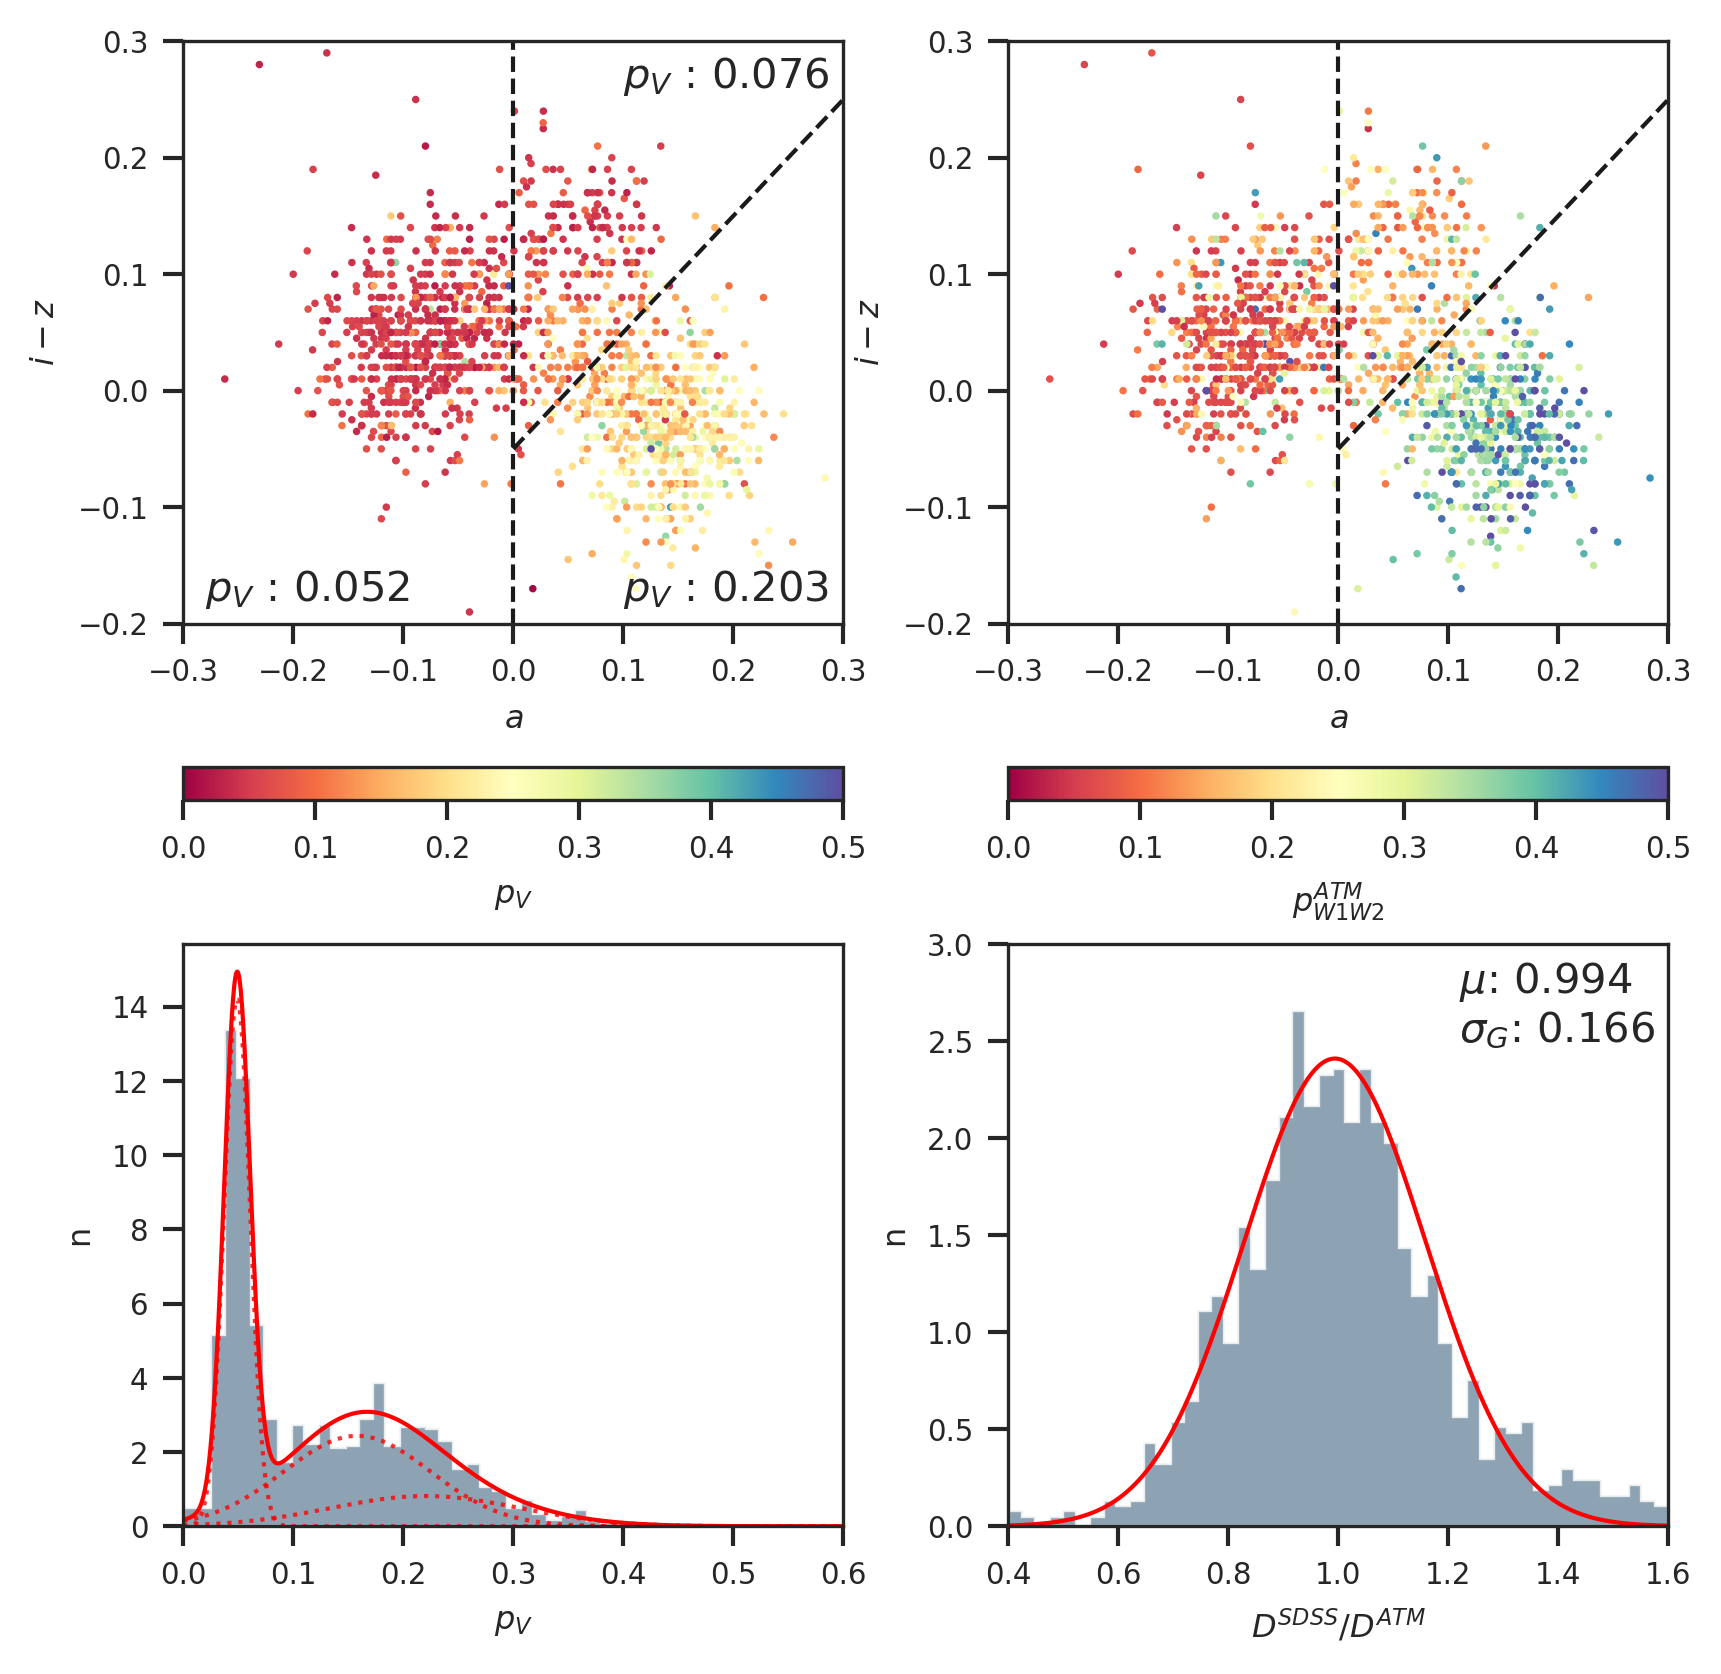

In [15]:
print("Filtered results: {}".format(len(filtered_results)))

histKwargs = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.8, 
    "normed" : True,
}
plotKwargs = {
    "ls" : "-",
    "lw" : 1,
    "c" : "red"
}

plotKwargsComponents = {
    "ls" : ":",
    "lw" : 1,
    "c" : "red",
    "alpha" : 0.8
}

verticalLines = {
    "lw" : 1,
    "linestyle" : "--",
}


fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.55)   

cbar_ax = fig.add_axes([0.05, 0.49, 0.40, 0.02])
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('top')
cm = ax[0,0].scatter(filtered_results["a_color_median"].values,
                filtered_results["i-z_median"].values,
                c=filtered_results["pv"].values,
                s=1,
                vmin=0.0,
                vmax=0.5,
                cmap="Spectral")
ax[0,0].vlines([0], -0.2, 0.3, **verticalLines)
a_grid = np.linspace(-0, 0.3, 20)
iz_model = -0.05 + 1.0*a_grid
ax[0,0].plot(a_grid,iz_model, c='k', lw=1, ls="--")
ax[0,0].set_ylabel("$i-z$")
ax[0,0].set_xlabel("$a$")
ax[0,0].set_xlim(-0.3, 0.3)
ax[0,0].set_ylim(-0.2, 0.3)
ax[0,0].text(-0.28, -0.18, r"$p_V$ : 0.052")
ax[0,0].text(0.10, 0.26, r"$p_V$ : 0.076")
ax[0,0].text(0.10, -0.18, r"$p_V$ : 0.203")
fig.colorbar(cm,
             cax=cbar_ax,
             label=r"$p_V$", 
             orientation="horizontal")

cbar_ax = fig.add_axes([0.55, 0.49, 0.40, 0.02])
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('top')
cm = ax[0,1].scatter(filtered_results["a_color_median"].values,
                filtered_results["i-z_median"].values,
                c=filtered_results["p_W1W2_median"].values,
                s=1,
                vmin=0.0,
                vmax=0.5,
                cmap="Spectral")
ax[0,1].vlines([0], -0.2, 0.3, **verticalLines)
a_grid = np.linspace(-0, 0.3, 20)
iz_model = -0.05 + 1.0*a_grid
ax[0,1].plot(a_grid,iz_model, c='k', lw=1, ls="--")
ax[0,1].set_ylabel("$i-z$")
ax[0,1].set_xlabel("$a$")
ax[0,1].set_xlim(-0.3, 0.3)
ax[0,1].set_ylim(-0.2, 0.3)
fig.colorbar(cm,
             cax=cbar_ax,
             label=r"$p_{W1W2}^{ATM}$", 
             orientation="horizontal")

ax[1,0], stats = plotHist(ax[1,0], 
                          filtered_results["pv"].values, 
                          [0, 0.6], 
                          numGauss=3,
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs,
                          plotKwargsComponents=plotKwargsComponents)
ax[1,0].set_xlabel("$p_V$")
ax[1,0].set_ylabel("n")#
ax[1,0].set_xlim(0.0, 0.6)
for gauss in stats:
    print("mu : {:.3f}".format(gauss[0]))
    print("sigma : {:.3f}".format(gauss[1]))
    print("weight : {:.3f}".format(gauss[2]))
    print("")
    
ax[1,1], stats = plotHist(ax[1,1], 
                          filtered_results["D_optical"].values / 10**filtered_results["logD_median"].values, 
                          [0.4, 1.6], 
                          numGauss=1,
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs,
                          plotKwargsComponents=plotKwargsComponents)
ax[1,1].set_xlabel("$D^{SDSS} / D^{ATM}$")
ax[1,1].set_ylabel("n")#
ax[1,1].set_xlim(0.4, 1.6)
ax[1,1].set_ylim(0, 3)
ax[1,1].set_xticks(np.arange(0.4, 1.8, 0.2))
ax[1,1].set_yticks(np.arange(0, 3.5, 0.5))
for gauss in [stats]:
    print("mu : {:.3f}".format(gauss[0]))
    print("sigma : {:.3f}".format(gauss[1]))
    print("weight : {:.3f}".format(gauss[2]))
    print("")
ax[1,1].text(1.22, 2.75, r"$\mu$: {:.3f}".format(stats[0]))
ax[1,1].text(1.22, 2.50, r"$\sigma_G$: {:.3f}".format(stats[1]))



if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "SDSS_diameter_albedo.{}".format(FORMAT)),
            bbox_inches='tight')

Filtered results: 1574
13


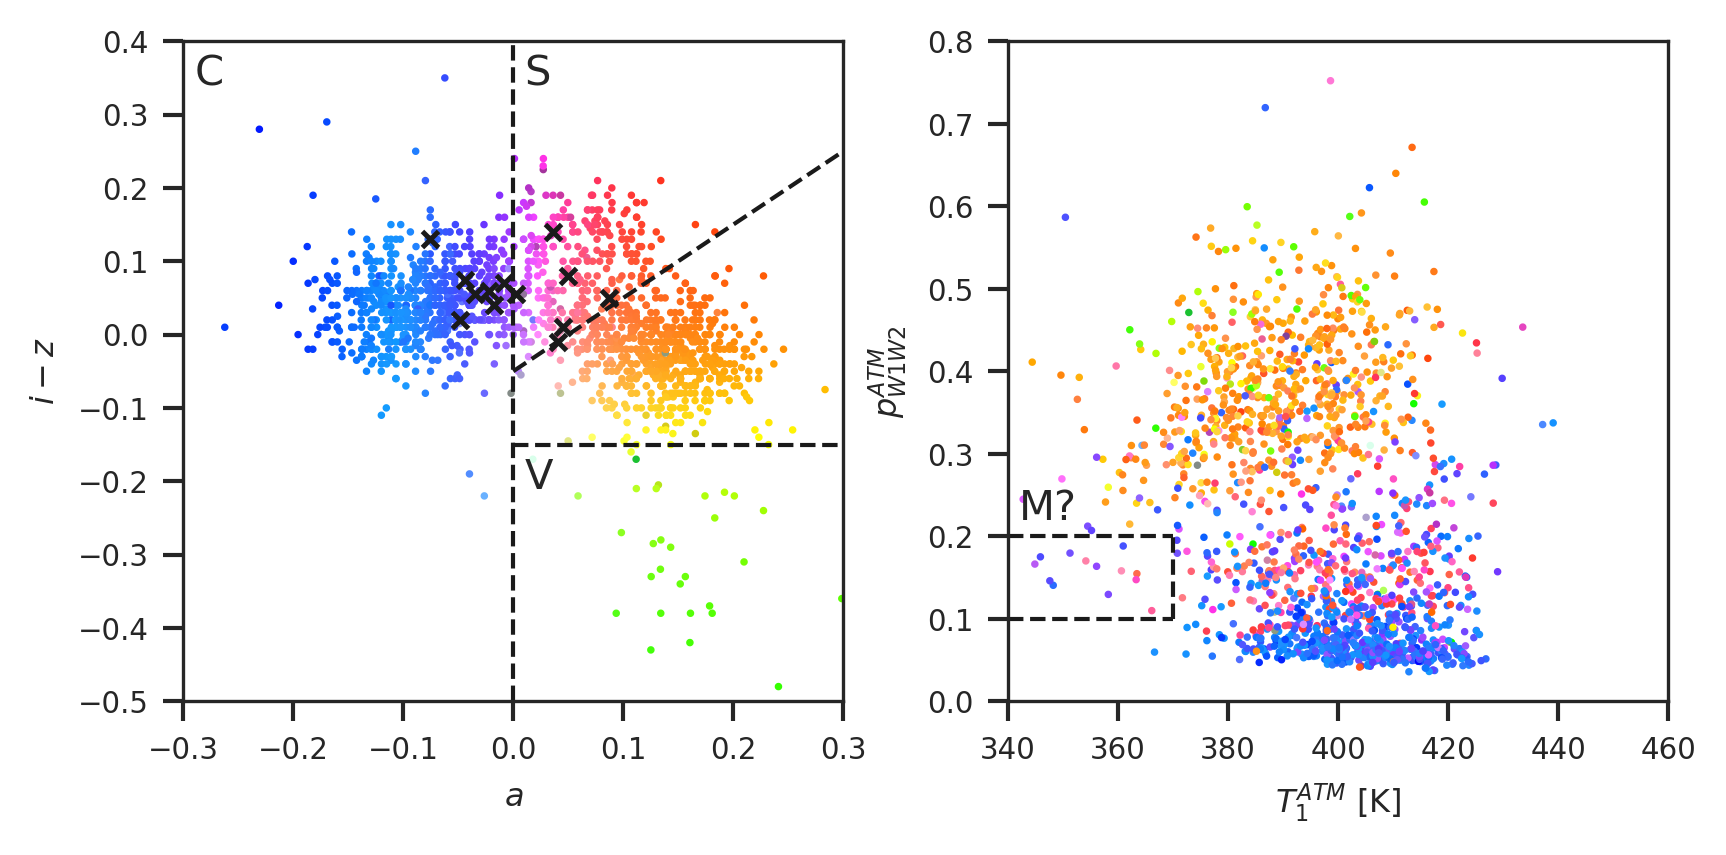

In [16]:
print("Filtered results: {}".format(len(filtered_results)))

metallic = filtered_results[(10**filtered_results["logT1_median"].values > 340)
                            & (10**filtered_results["logT1_median"].values < 370)
                            & (filtered_results["p_W1W2_median"].values < 0.20)
                            & (filtered_results["p_W1W2_median"].values > 0.10)].copy()
print(len(metallic))

histKwargs = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.8, 
    "normed" : True,
}
plotKwargs = {
    "ls" : "-",
    "lw" : 1,
    "c" : "red"
}

plotKwargsComponents = {
    "ls" : ":",
    "lw" : 1,
    "c" : "red",
    "alpha" : 0.8
}

verticalLines = {
    "lw" : 1,
    "linestyle" : "--",
}


fig, ax = plt.subplots(1, 2, dpi=DPI, figsize=(5.5, 5.5/2.25))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.55)   

ax[0].scatter(filtered_results["a_color_median"].values,
              filtered_results["i-z_median"].values,
              c=filtered_results[["r_color_median", "g_color_median", "b_color_median"]].values,
                s=1)
ax[0].scatter(metallic["a_color_median"].values,
              metallic["i-z_median"].values,
              c="k",
              marker="x",
              s=15)
ax[0].vlines([0], -0.5, 0.4, **verticalLines)
ax[0].hlines([-0.15], 0, 0.3, **verticalLines)
a_grid = np.linspace(-0, 0.4, 20)
iz_model = -0.05 + 1.0*a_grid
ax[0].plot(a_grid,iz_model, c='k', lw=1, ls="--")
ax[0].set_ylabel("$i-z$")
ax[0].set_xlabel("$a$")
ax[0].set_xlim(-0.3, 0.3)
ax[0].set_ylim(-0.5, 0.4)
ax[0].text(-0.29, 0.34, 'C')
ax[0].text(0.01, 0.34, 'S')
ax[0].text(0.01, -0.21, 'V')

ax[1].scatter(10**filtered_results["logT1_median"].values,
              filtered_results["p_W1W2_median"].values,
              c=filtered_results[["r_color_median", "g_color_median", "b_color_median"]].values,
              s=1)

ax[1].set_ylabel(r"$p_{W1W2}^{ATM}$")
ax[1].set_xlabel(r"$T_1^{ATM}$ [K]")
ax[1].set_xlim(340, 460)
ax[1].set_ylim(0, 0.8)
ax[1].hlines([0.10,0.20], 340, 370, **verticalLines)
ax[1].vlines([370], 0.1, 0.20, **verticalLines)
ax[1].text(342, 0.22, "M?")

if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "SDSS_metallic.{}".format(FORMAT)),
            bbox_inches='tight')

In [17]:
metallic

,numeration,run_median,run_sigmaG,col_median,col_sigmaG,field_median,field_sigmaG,object_median,object_sigmaG,rowc_median,...,W1-W2_sigmaG,W2-W3_median,W2-W3_sigmaG,W3-W4_median,W3-W4_sigmaG,pv,p_W1W2_median,p_W1W2_sigmaG,pv_assigned,D_optical
260,1349,5893.5,58.19205,5.0,0.74130,151.5,21.86835,53.5,33.729150,532.2160,...,0.271316,7.5960,0.428471,2.9730,0.071906,0.135201,0.175050,0.033427,0.052,47154.517907
378,1546,4253.0,694.59810,1.0,0.37065,142.0,5.55975,49.0,8.524950,1156.2800,...,0.090068,7.5540,0.115643,2.7770,0.035212,0.106389,0.179582,0.021977,0.052,42026.508322
456,1670,2190.0,0.00000,4.0,0.00000,109.0,0.00000,81.0,0.000000,1070.8900,...,0.203487,7.5000,0.192738,2.6500,0.051150,0.102844,0.170096,0.012056,0.076,26984.736697
487,1730,2723.5,10.74885,2.0,0.74130,104.0,15.56730,111.5,38.176950,828.4475,...,0.104523,7.5470,0.174205,2.6550,0.024463,0.103886,0.166279,0.018448,0.076,19103.730587
490,1732,4151.0,4.44780,4.5,0.37065,207.5,87.84405,46.0,26.686800,744.8035,...,0.228691,7.6930,0.467019,2.6890,0.072647,0.107014,0.154635,0.019394,0.076,29588.175417
573,1860,4508.0,0.00000,4.0,0.00000,77.0,0.00000,329.0,0.000000,1350.6500,...,0.093960,7.2850,0.115828,2.4665,0.041698,0.116903,0.129504,0.008729,0.052,27894.803672
639,1977,5183.0,4.44780,3.0,0.37065,174.0,41.88345,49.0,16.679250,1049.7700,...,0.126577,7.5450,0.248150,2.6355,0.026316,0.111285,0.163571,0.015615,0.052,28152.911113
761,2294,4335.0,0.00000,3.0,0.00000,72.0,0.00000,47.0,0.000000,146.8030,...,0.076354,7.3960,0.084879,2.5260,0.012231,0.114644,0.158069,0.014380,0.203,12071.937046
861,2573,5038.0,0.00000,6.0,0.00000,161.0,0.00000,116.0,0.000000,1385.0100,...,0.213124,7.8040,0.076169,2.7180,0.030208,0.063870,0.109851,0.010819,0.076,19369.489953
968,2904,4381.0,0.00000,1.0,0.00000,176.0,0.00000,67.0,0.000000,685.4670,...,0.137696,7.4025,0.111010,2.5725,0.040957,0.122992,0.188187,0.015127,0.052,24861.269942


In [18]:
specB_list = []
specT_list = []

for numeration in metallic["numeration"].values:
    
    sbdb_obj = SBDB.query(numeration, phys=True)
    try:
        specB = sbdb_obj["phys_par"]["spec_B"]
    except:
        specB = None

    try:
        specT = sbdb_obj["phys_par"]["spec_T"]
    except:
        specT = None
    
    specB_list.append(specB)
    specT_list.append(specT)
    
metallic["spec_B"] = specB_list
metallic["spec_T"] = specT_list

In [19]:
metallic

,numeration,run_median,run_sigmaG,col_median,col_sigmaG,field_median,field_sigmaG,object_median,object_sigmaG,rowc_median,...,W2-W3_sigmaG,W3-W4_median,W3-W4_sigmaG,pv,p_W1W2_median,p_W1W2_sigmaG,pv_assigned,D_optical,spec_B,spec_T
260,1349,5893.5,58.19205,5.0,0.74130,151.5,21.86835,53.5,33.729150,532.2160,...,0.428471,2.9730,0.071906,0.135201,0.175050,0.033427,0.052,47154.517907,None,None
378,1546,4253.0,694.59810,1.0,0.37065,142.0,5.55975,49.0,8.524950,1156.2800,...,0.115643,2.7770,0.035212,0.106389,0.179582,0.021977,0.052,42026.508322,None,None
456,1670,2190.0,0.00000,4.0,0.00000,109.0,0.00000,81.0,0.000000,1070.8900,...,0.192738,2.6500,0.051150,0.102844,0.170096,0.012056,0.076,26984.736697,None,None
487,1730,2723.5,10.74885,2.0,0.74130,104.0,15.56730,111.5,38.176950,828.4475,...,0.174205,2.6550,0.024463,0.103886,0.166279,0.018448,0.076,19103.730587,Xe,None
490,1732,4151.0,4.44780,4.5,0.37065,207.5,87.84405,46.0,26.686800,744.8035,...,0.467019,2.6890,0.072647,0.107014,0.154635,0.019394,0.076,29588.175417,None,None
573,1860,4508.0,0.00000,4.0,0.00000,77.0,0.00000,329.0,0.000000,1350.6500,...,0.115828,2.4665,0.041698,0.116903,0.129504,0.008729,0.052,27894.803672,X,None
639,1977,5183.0,4.44780,3.0,0.37065,174.0,41.88345,49.0,16.679250,1049.7700,...,0.248150,2.6355,0.026316,0.111285,0.163571,0.015615,0.052,28152.911113,Sq,None
761,2294,4335.0,0.00000,3.0,0.00000,72.0,0.00000,47.0,0.000000,146.8030,...,0.084879,2.5260,0.012231,0.114644,0.158069,0.014380,0.203,12071.937046,None,None
861,2573,5038.0,0.00000,6.0,0.00000,161.0,0.00000,116.0,0.000000,1385.0100,...,0.076169,2.7180,0.030208,0.063870,0.109851,0.010819,0.076,19369.489953,None,None
968,2904,4381.0,0.00000,1.0,0.00000,176.0,0.00000,67.0,0.000000,685.4670,...,0.111010,2.5725,0.040957,0.122992,0.188187,0.015127,0.052,24861.269942,None,None


In [20]:
# KS test, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
aAll = filtered_results[~filtered_results["numeration"].isin(metallic["numeration"].values)]["a_color_median"].values
aMetallic = filtered_results[filtered_results["numeration"].isin(metallic["numeration"].values)]["a_color_median"].values
scipy.stats.ks_2samp(aAll[np.abs(aAll) < 0.4], aMetallic)

Ks_2sampResult(statistic=0.4062375448385812, pvalue=0.019716523124324342)

In [21]:
# KS test, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
aAll = filtered_results[~filtered_results["numeration"].isin(metallic["numeration"].values)]["a_color_median"].values
aMetallic = filtered_results[filtered_results["numeration"].isin(metallic["numeration"].values)]["a_color_median"].values
scipy.stats.ks_2samp(aAll, aMetallic)

Ks_2sampResult(statistic=0.410584930764303, pvalue=0.017843675748455655)

In [23]:
table = metallic[["numeration", "g-r_median", "r-i_median", 
                  "logD_median", "logD_sigmaG", 
                  "logT1_median", "logT1_sigmaG",
                  "p_W1W2_median", "p_W1W2_sigmaG", "spec_T", "spec_B"]].copy()
table["numeration"] = table["numeration"].astype(int)
table.sort_values(by="numeration", inplace=True)

table["$logD$"] = np.round(table["logD_median"], 3)
table["$\sigma_{logD}$"] = np.round(table["logD_sigmaG"], 3)
table["$logT_1$"] = np.round(table["logT1_median"], 3)
table["$\sigma_{logT_1}$"] = np.round(table["logT1_sigmaG"], 3)
table["$p_{W1W2}$"] = np.round(table["p_W1W2_median"], 3)
table["$\sigma_{p_{W1W2}}$"] = np.round(table["p_W1W2_sigmaG"], 3)
table["g-r"] =  np.round(table["g-r_median"], 2)
table["r-i"] =  np.round(table["r-i_median"], 2)
table["designation"] = "(" + table["numeration"].astype("str") + ")"
table = table[["designation", "g-r", "r-i", "$logD$", "$\sigma_{logD}$", "$logT_1$", "$\sigma_{logT_1}$", "$p_{W1W2}$", "$\sigma_{p_{W1W2}}$", "spec_T", "spec_B"]]
table.rename(columns={"spec_B" : "spectral class [SMASSII]",
                      "spec_T" : "spectral class [Tholen]"})
table.to_csv("metallic_candidates.txt", index=False, sep=" ")